In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from time import time

import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.distributions as TD

import numpy as np
from matplotlib import pyplot as plt

import sys
sys.path.append('../../homeworks') # to grab dgm_utils from ../../homeworks directory
from tqdm.notebook import tqdm

if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 1
    torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE='cpu'
# DEVICE='cpu'

import warnings
warnings.filterwarnings('ignore')

# dgm_utils
from dgm_utils import train_model, show_samples, visualize_images
from dgm_utils import visualize_2d_samples, visualize_2d_densities, visualize_2d_data

def reset_seed():
    OUTPUT_SEED = 0xBADBEEF
    torch.manual_seed(OUTPUT_SEED)
    np.random.seed(OUTPUT_SEED)

reset_seed()

# <center>Deep Generative Models</center>
## <center>Seminar 9</center>

<center><img src="pics/mipt_logo.png" width=600 /></center>
<center>31.10.2023</center>


## Plan

1. Wasserstein GANs on multimodal 2D data
     
     - Vanilla GAN
     
     - WGAN
     
     - WGAN-GP
     
     - SNGAN

2. GANs zoo

3. Evolution of GANs

4. StyleGAN details

## Vanilla GAN,  WGAN and WGAN-GP on 2D data

In [3]:
def generate_2d_data(size, var=0.02):
    scale = 2
    centers = [
        (1, 0),
        (-1, 0),
        (0, 1),
        (0, -1),
        (1. / np.sqrt(2), 1. / np.sqrt(2)),
        (1. / np.sqrt(2), -1. / np.sqrt(2)),
        (-1. / np.sqrt(2), 1. / np.sqrt(2)),
        (-1. / np.sqrt(2), -1. / np.sqrt(2))
    ]

    centers = [(scale * x, scale * y) for x, y in centers]
    dataset = []

    for i in range(size):
        point = np.random.randn(2) * var
        center = centers[np.random.choice(np.arange(len(centers)))]
        point[0] += center[0]
        point[1] += center[1]
        dataset.append(point)

    dataset = np.array(dataset, dtype='float32')
    dataset /= 1.414  # stdev

    return dataset

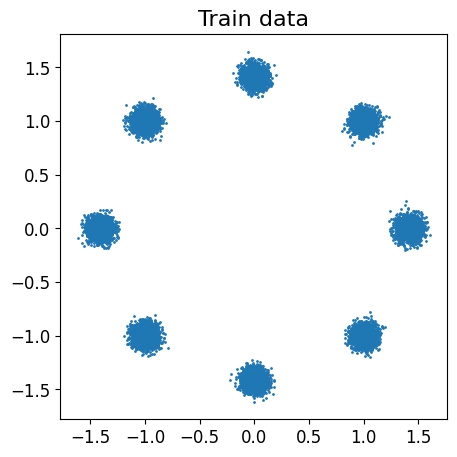

In [4]:
reset_seed()
COUNT = 20000

train_data = generate_2d_data(COUNT, var=0.08) # 0.02, 0.1, 0.4
visualize_2d_samples(train_data, "Train data")

Visualization functions

In [5]:
from seminar9_utils import make_inference, visualize_GAN_output

def plot_losses(losses, title):
    n_itr = len(losses)
    xs = np.arange(n_itr)

    plt.figure(figsize=(7, 5))
    plt.plot(xs, losses)
    plt.title(title, fontsize=14)
    plt.xlabel('Iterations', fontsize=14)
    plt.ylabel('Loss', fontsize=14)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

# Vanilla GAN

<img src="pics/gan_objective.jpg" width=800 height=800 />

In [6]:
from seminar9_utils import FullyConnectedMLP

`GAN` generator

In [7]:
class MLPGenerator(FullyConnectedMLP):

    def sample(self, n):
        z = torch.randn(size=(n, self.input_dim)).to(
            next(iter(self.parameters())))
        return self.forward(z)

`GAN` discriminator

In [8]:
class MLPDiscriminator(FullyConnectedMLP):

    pass

`GAN` training loop

In [9]:
def train_gan(
    generator, 
    discriminator, 
    train_loader,
    discriminator_steps, 
    batch_size,
    n_epochs,
    lr,
    visualize_steps=10):

    # \beta_1 = 0 !!!
    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0, 0.9))
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0, 0.9))

    generator.train()
    discriminator.train()

    curr_iter = 0
    d_loss, g_loss = torch.zeros(1), torch.zeros(1)
    batch_loss_history = {'discriminator_losses': [], 'generator_losses': []}

    for epoch_i in tqdm(range(n_epochs)):
        for (batch_i, real_data) in enumerate(train_loader):
            curr_iter += 1
            real_data = real_data.to(DEVICE)

            # DISCRIMINATOR UPDATE
            with torch.no_grad():
                fake_data = generator.sample(real_data.shape[0])

            real_scores = discriminator(real_data)
            real_predict = F.softplus(- real_scores).mean()
            fake_scores = discriminator(fake_data)
            fake_predict = F.softplus(fake_scores).mean()

            discriminator_optimizer.zero_grad()
            d_loss = real_predict + fake_predict
            d_loss.backward()
            discriminator_optimizer.step()

            # GENERATOR UPDATE
            if curr_iter % discriminator_steps == 0:
                gen_optimizer.zero_grad()
                fake_data = generator.sample(batch_size)
                fake_scores = discriminator(fake_data)
                # implements Non-saturating GAN loss
                g_loss = F.softplus(-fake_scores).mean()
                g_loss.backward()
                gen_optimizer.step()

                batch_loss_history['generator_losses'].append(g_loss.data.cpu().numpy())
                batch_loss_history['discriminator_losses'].append(d_loss.data.cpu().numpy())

        if visualize_steps and epoch_i % visualize_steps == 0:
            print('Epoch {}'.format(epoch_i))
            samples, grid, discr_output, discr_grad_norms = make_inference(generator, discriminator)
            visualize_GAN_output(samples, train_data, grid, discr_output, discr_grad_norms)

    return batch_loss_history

`GAN` training

In [37]:
# CRITIC_STEPS = 5 => MODE COLLAPSE (SATURATING), NO LEARNING (NOT SATURATING)
# CRITIC_STEPS = 1 => NO MODE COLLAPSE 
reset_seed()
BATCH_SIZE = 1024 # any adequate value
GEN_HIDDENS = [32, 128, 128, 32] # 4 layers with < 128 neurons would be enough
DISCR_HIDDENS = [64, 256, 256, 64] # 4 layers with < 128 neurons would be enough
CRITIC_STEPS = 1 # take 1/2
LR = 2e-4 # < 1e-2

N_EPOCHS = 100 # change it if you want

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

generator = MLPGenerator(16, GEN_HIDDENS, 2).to(DEVICE)
discriminator = MLPDiscriminator(2, DISCR_HIDDENS, 1).to(DEVICE)

train_losses = train_gan(
    generator, 
    discriminator, 
    train_loader,
    discriminator_steps=CRITIC_STEPS, 
    batch_size=BATCH_SIZE, 
    n_epochs=N_EPOCHS,
    lr=LR,
    visualize_steps=20
)

plot_losses(train_losses['discriminator_losses'], 'Critic loss')
plot_losses(train_losses['generator_losses'], 'Generator loss')

In [39]:
samples, grid, discr_output, discr_grad_norms = make_inference(generator, discriminator)
visualize_GAN_output(samples, train_data, grid, discr_output, discr_grad_norms)

**Practical Note**:

Use **RMSProp** or **Adam** with $\beta_1 = 0$ when training your GAN. Large $\beta_1$ of Adam leads to training instabilities!

## WGAN

[WGAN](https://arxiv.org/abs/1701.07875) model uses weight clipping to enforce Lipschitzness of the critic.

The model objective is
$$
\min_{G} W(\pi || p) \approx \min_{G} \max_{\boldsymbol{\phi} \in \boldsymbol{\Phi}} \left[ \mathbb{E}_{\pi(\mathbf{x})} f(\mathbf{x}, \boldsymbol{\phi})  - \mathbb{E}_{p(\mathbf{z})} f(G(\mathbf{z}, \boldsymbol{\theta}), \boldsymbol{\phi} )\right].
$$
Here $f(\mathbf{x}, \boldsymbol{\phi})$ is the critic model. The critic weights $\boldsymbol{\phi}$ should lie in the compact set $\boldsymbol{\Phi} = [-c, c]^d$.

<img src="pics/wgan_alg.jpg" width=800 height=800 />

`WGAN` generator model

In [10]:
class WGAN_MLPGenerator(MLPGenerator):
    pass

`WGAN` discriminator model

In [11]:
from wgan import WGAN_MLPCritic

`WGAN` train loop

In [12]:
from wgan import train_wgan

Playing with `WGAN`

In [40]:
reset_seed()
BATCH_SIZE = 1024 # any adequate value
GEN_HIDDENS = [32, 128, 128, 32] # 4 layers with < 128 neurons would be enough
DISCR_HIDDENS = [64, 256, 256, 64] # 4 layers with < 128 neurons would be enough
CRITIC_STEPS = 5 # > 2
LR = 2e-4 # < 1e-2
CLIP_C = 0.05 # < 1

N_EPOCHS = 10 # change it if you want

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

generator = WGAN_MLPGenerator(16, GEN_HIDDENS, 2).to(DEVICE)
critic = WGAN_MLPCritic(2, DISCR_HIDDENS, 1).to(DEVICE)

train_losses = train_wgan(
    generator, 
    critic, 
    train_loader,
    critic_steps=CRITIC_STEPS, 
    batch_size=BATCH_SIZE, 
    n_epochs=N_EPOCHS,
    lr=LR,
    clip_c=CLIP_C,
    visualize_steps=1
)

plot_losses(train_losses['discriminator_losses'], 'Critic loss')
plot_losses(train_losses['generator_losses'], 'Generator loss')

`WGAN` training

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 0


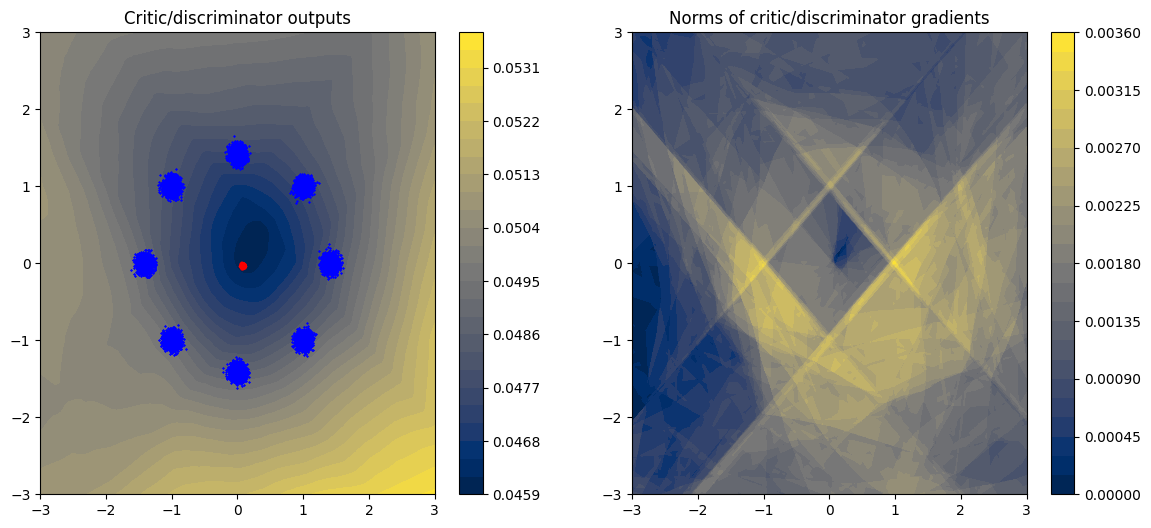

Epoch 50


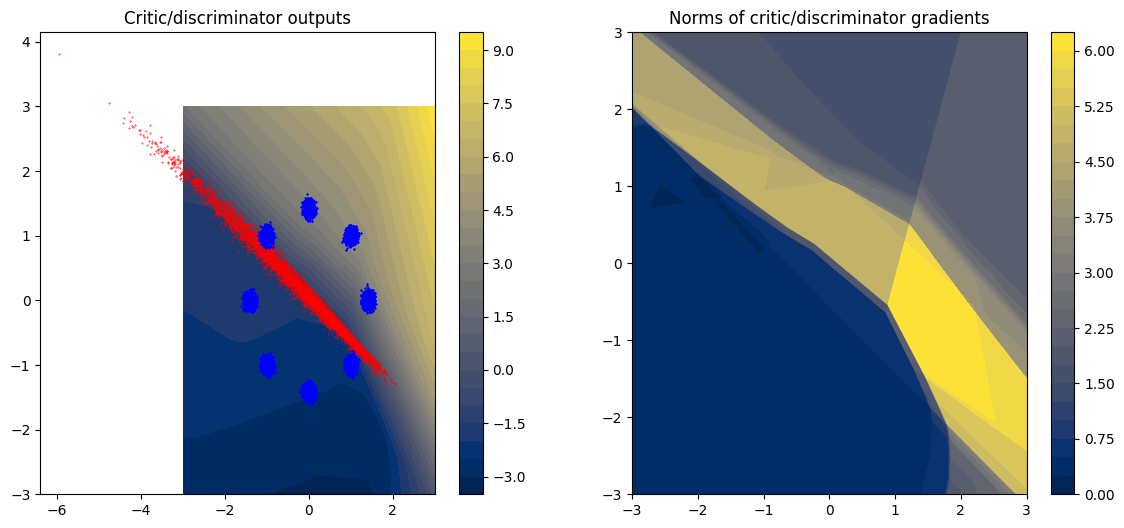

Epoch 100


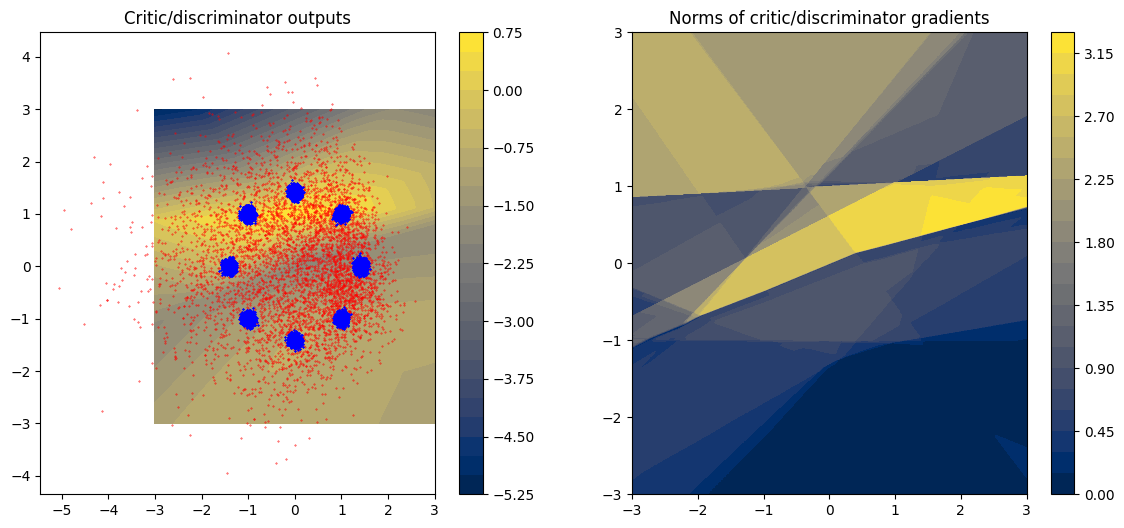

Epoch 150


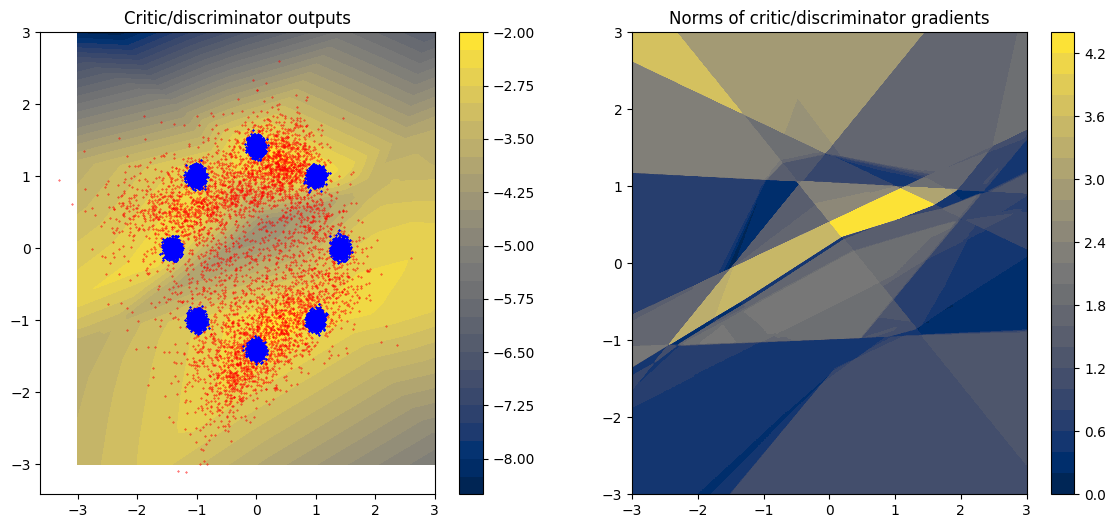

Epoch 200


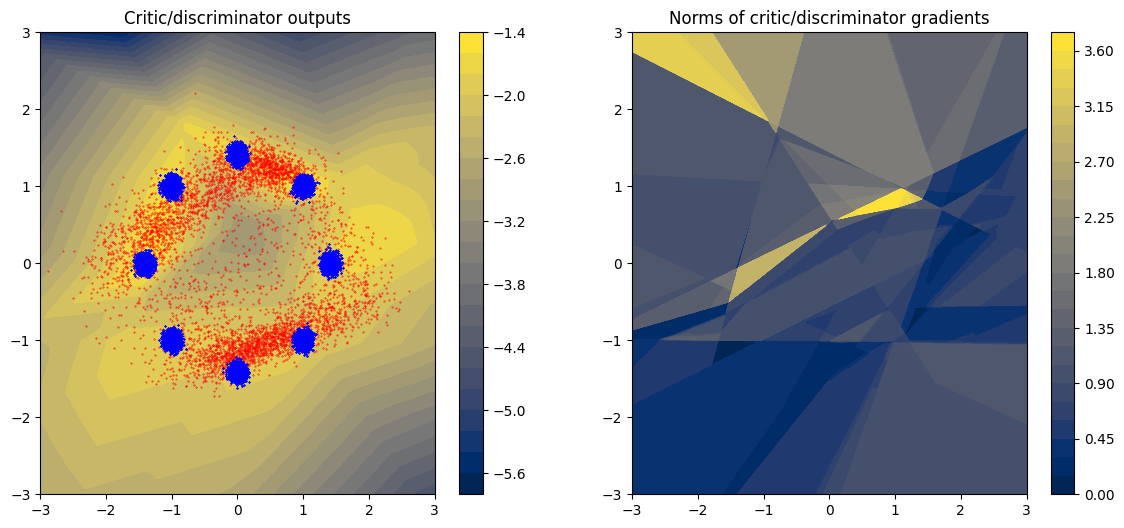

Epoch 250


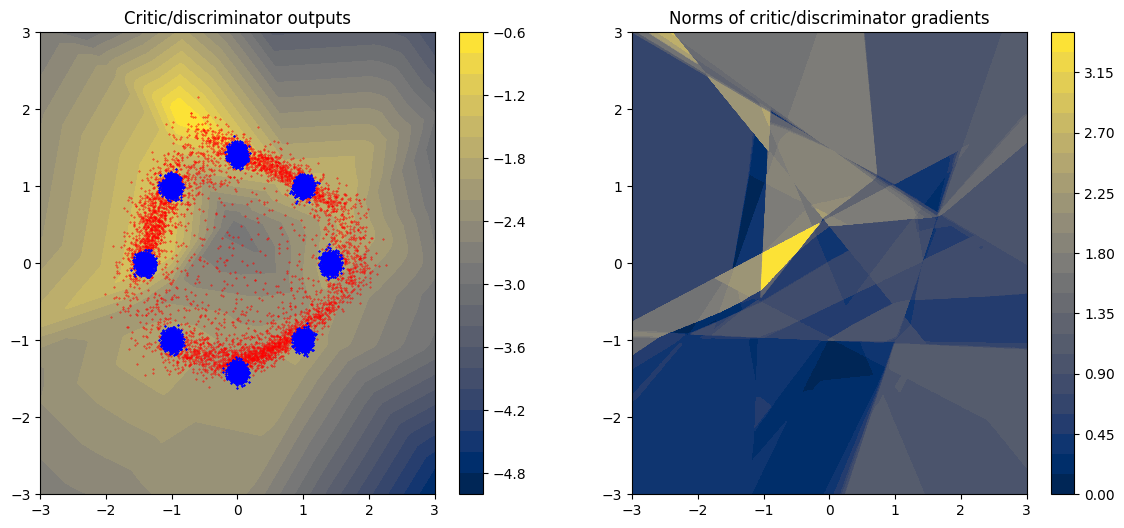

Epoch 300


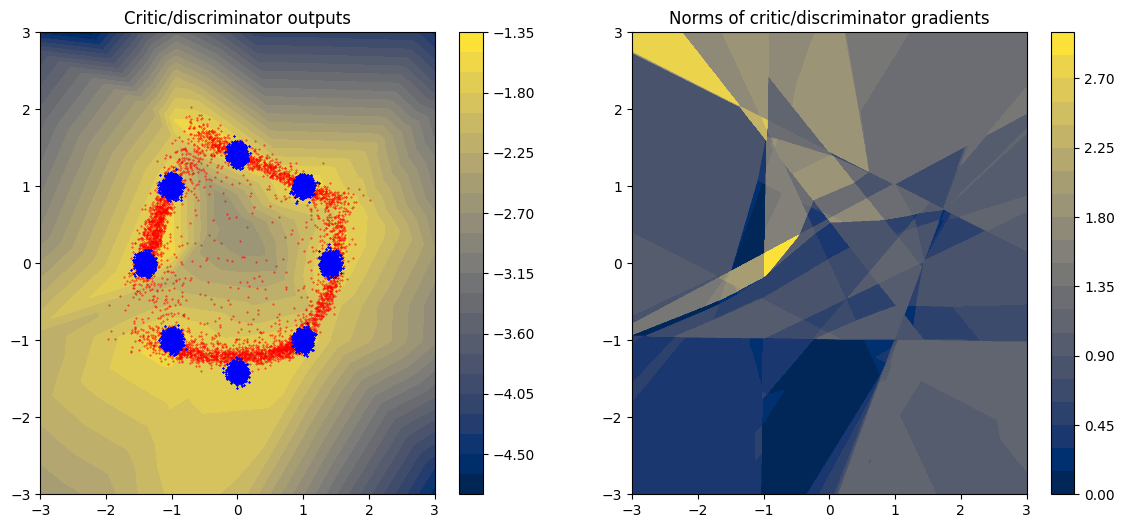

Epoch 350


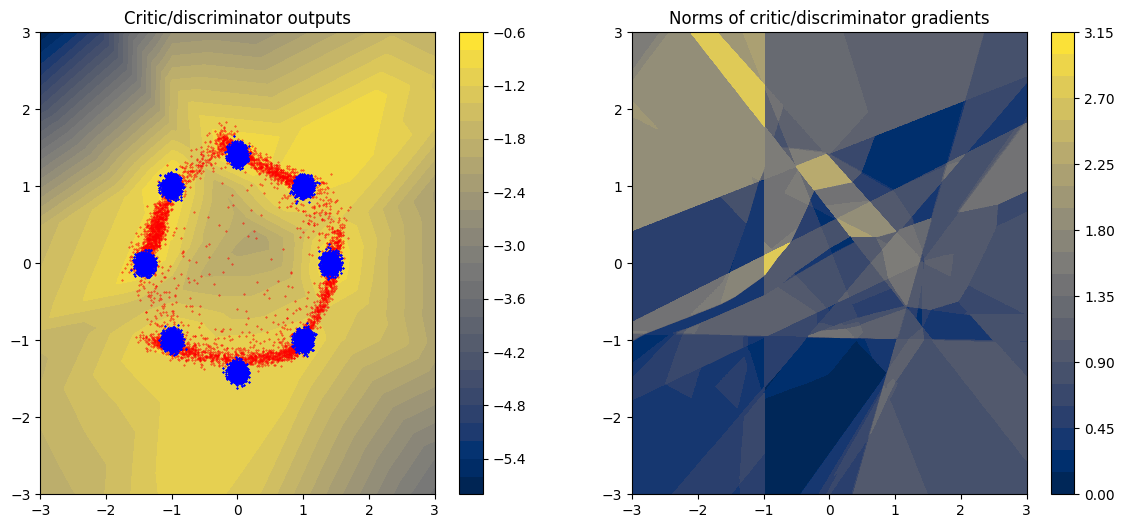

Epoch 400


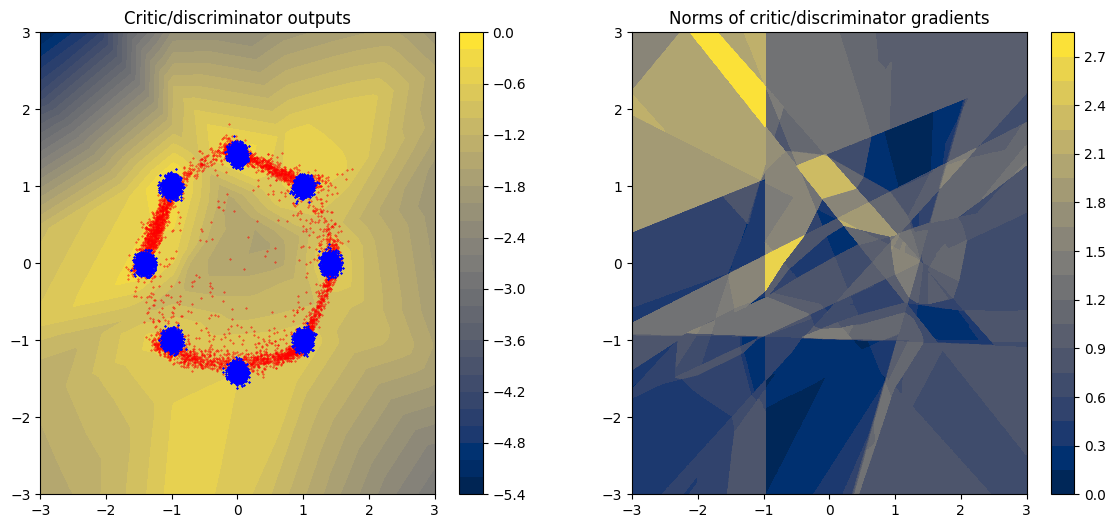

Epoch 450


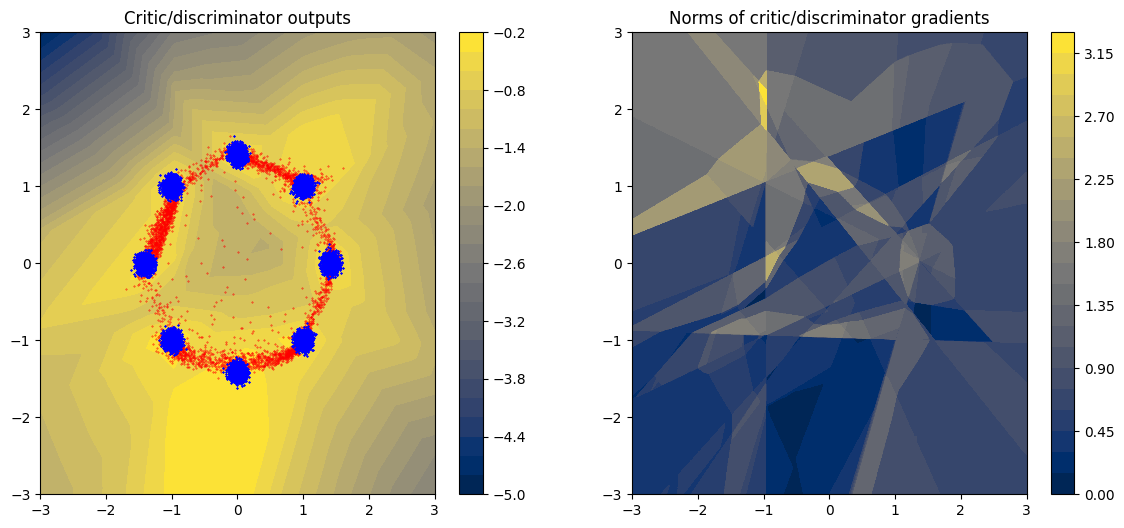

Epoch 500


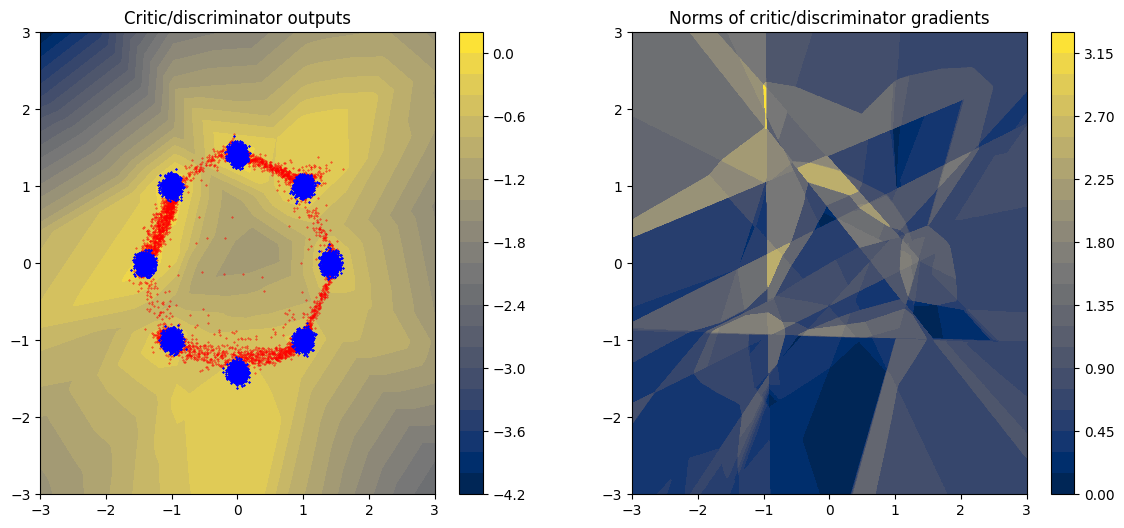

Epoch 550


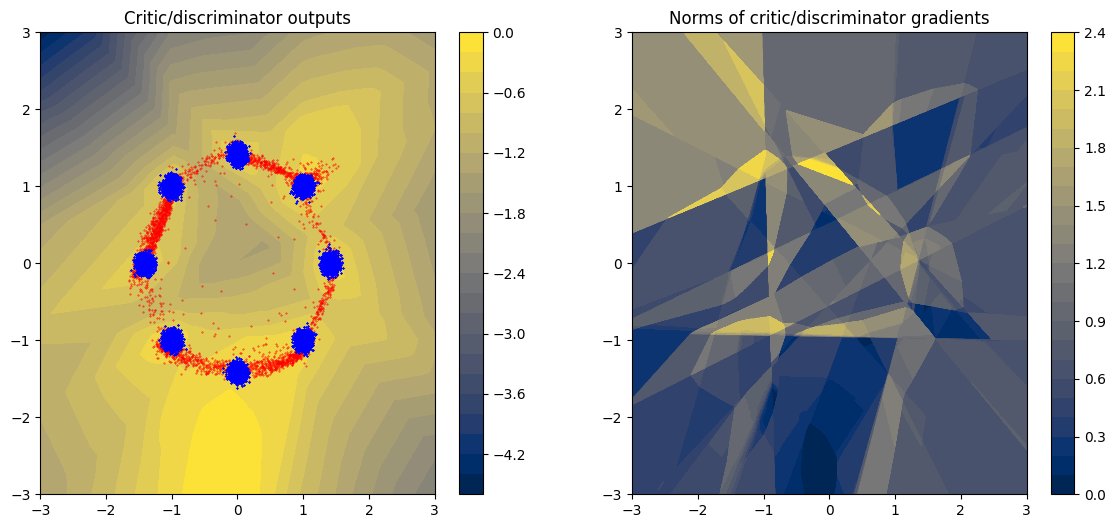

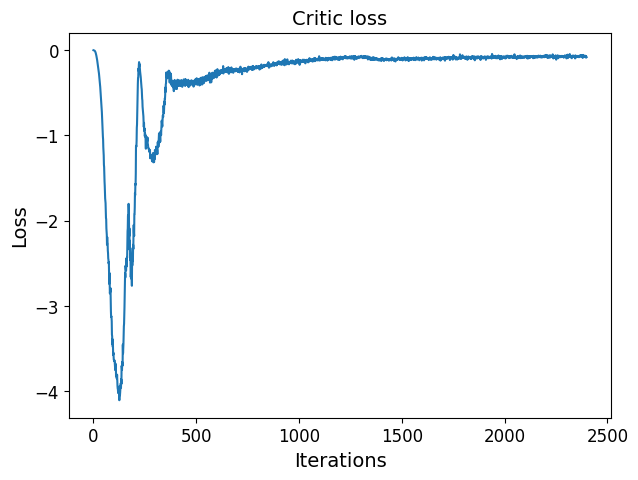

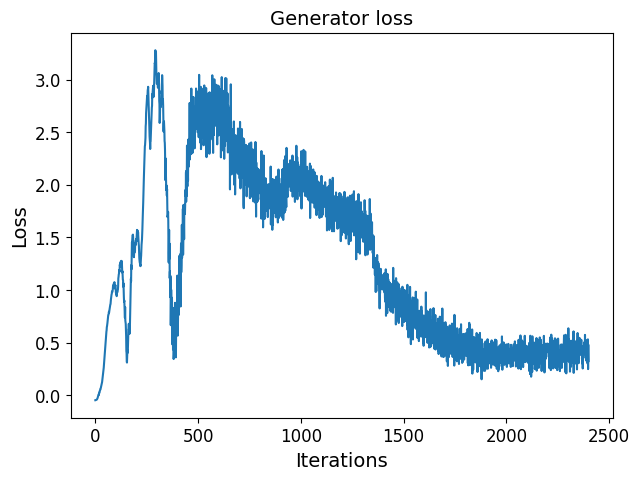

In [13]:
# CRITIC_STEPS = 5 => more or less learning
# CRITIC_STEPS = 1 => no learning

reset_seed()
BATCH_SIZE = 1024 # any adequate value
GEN_HIDDENS = [32, 128, 128, 32] # 4 layers with < 128 neurons would be enough
DISCR_HIDDENS = [64, 256, 256, 64] # 4 layers with < 128 neurons would be enough
CRITIC_STEPS = 5 # > 2
LR = 2e-4 # < 1e-2
CLIP_C = 0.05 # < 1

N_EPOCHS = 600 # change it if you want

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

generator = WGAN_MLPGenerator(16, GEN_HIDDENS, 2).to(DEVICE)
critic = WGAN_MLPCritic(2, DISCR_HIDDENS, 1).to(DEVICE)

train_losses = train_wgan(
    generator, 
    critic, 
    train_loader,
    critic_steps=CRITIC_STEPS, 
    batch_size=BATCH_SIZE, 
    n_epochs=N_EPOCHS,
    lr=LR,
    clip_c=CLIP_C,
    visualize_steps=50
)

plot_losses(train_losses['discriminator_losses'], 'Critic loss')
plot_losses(train_losses['generator_losses'], 'Generator loss')

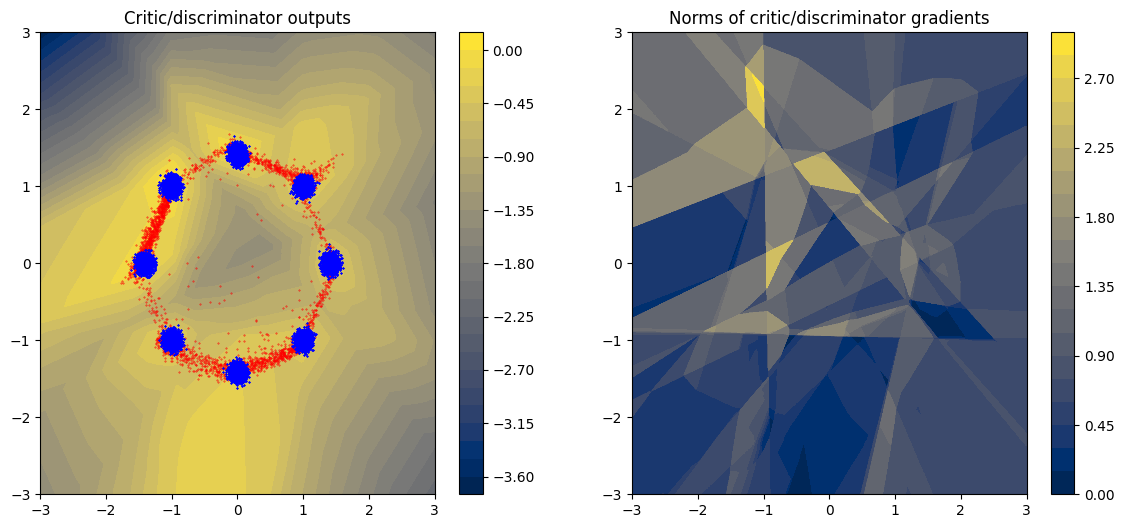

In [14]:
samples, grid, critic_output, critic_grad_norms = make_inference(generator, critic)
visualize_GAN_output(samples, train_data, grid, critic_output, critic_grad_norms)

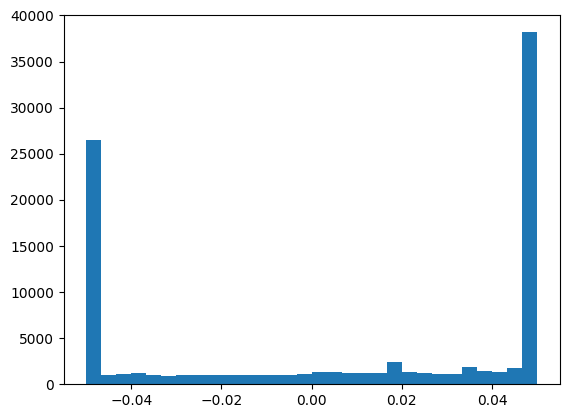

In [15]:
params = []
for param in critic.parameters():
    params.extend(param.detach().cpu().numpy().flatten())
plt.hist(params, bins=30)
plt.show()

## WGAN-GP

[WGAN-GP](https://arxiv.org/pdf/1704.00028.pdf)  model uses gradient penalty to enforce Lipschitzness.

The model objective is
$$
    W(\pi || p) = \underbrace{\mathbb{E}_{\pi(\mathbf{x})} f(\mathbf{x})  - \mathbb{E}_{p(\mathbf{x} | \boldsymbol{\theta})} f(\mathbf{x})}_{\text{original critic loss}} + \lambda \underbrace{\mathbb{E}_{U[0, 1]} \left[ \left( \| \nabla_{\hat{\mathbf{x}}} f(\hat{\mathbf{x}}) \|_2 - 1 \right) ^ 2\right]}_{\text{gradient penalty}},
$$
where the samples $\hat{\mathbf{x}}_t = t \mathbf{x} + (1 - t) \mathbf{y}$ with $t \in [0, 1]$ are uniformly sampled along straight lines between pairs of points: $\mathbf{x}$ from the data distribution $\pi(\mathbf{x})$ and $\mathbf{y}$ from the generator distribution $p(\mathbf{x} | \boldsymbol{\theta}))$.

<img src="pics/WGAN-GP_theorem.jpg" width=800 height=800 />

<img src="pics/wgan-gp_alg.jpg" width=800 height=800 />

In [16]:
from wgan_gp import train_wgan_gp

`WGAN-GP` generator model

In [17]:
class WGANGP_MLPGenerator(MLPGenerator):
    pass

`WGAN-GP` discriminator model

In [18]:
class WGANGP_MLPCritic(FullyConnectedMLP):
    pass

Playing with `WGAN-GP`

In [44]:
reset_seed()
BATCH_SIZE = 1024 # any adequate value
GEN_HIDDENS = [32, 128, 128, 32] # 4 layers with < 128 neurons would be enough
DISCR_HIDDENS = [64, 256, 256, 64] # 4 layers with < 128 neurons would be enough
CRITIC_STEPS = 5 # > 2
LR = 2e-4 # < 1e-2
GP_WEIGHT = 10 # > 5

N_EPOCHS = 10 # change it if you want

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

generator = WGANGP_MLPGenerator(16, GEN_HIDDENS, 2).to(DEVICE)
critic = WGANGP_MLPCritic(2, DISCR_HIDDENS, 1).to(DEVICE)

train_losses = train_wgan_gp(
    generator, 
    critic, 
    train_loader,
    critic_steps=CRITIC_STEPS, 
    batch_size=BATCH_SIZE, 
    n_epochs=N_EPOCHS,
    lr=LR,
    gp_weight=GP_WEIGHT,
    visualize_steps=1
)

plot_losses(train_losses['discriminator_losses'], 'Critic loss')
plot_losses(train_losses['generator_losses'], 'Generator loss')

`WGAN-GP` training

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 0


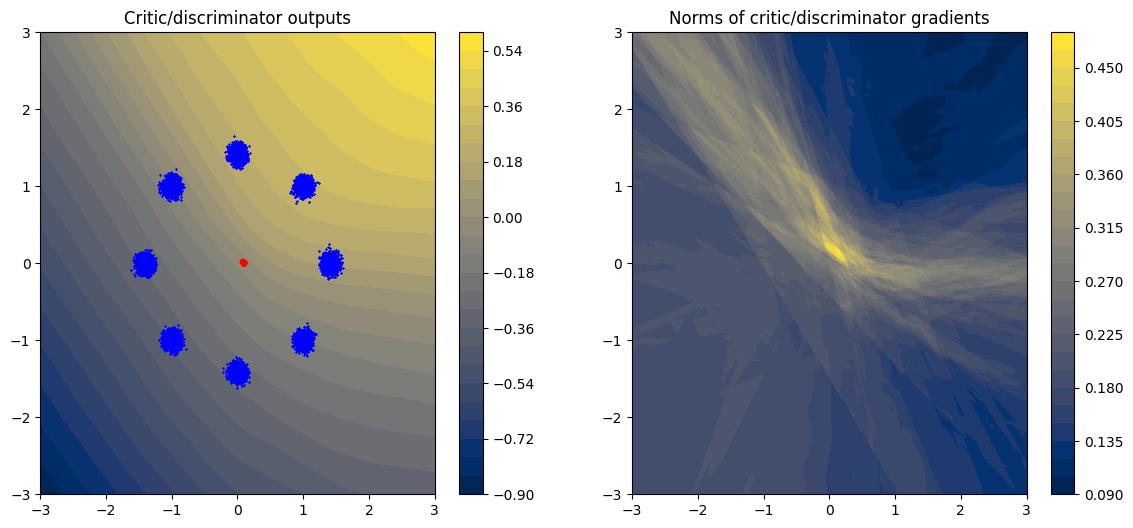

Epoch 50


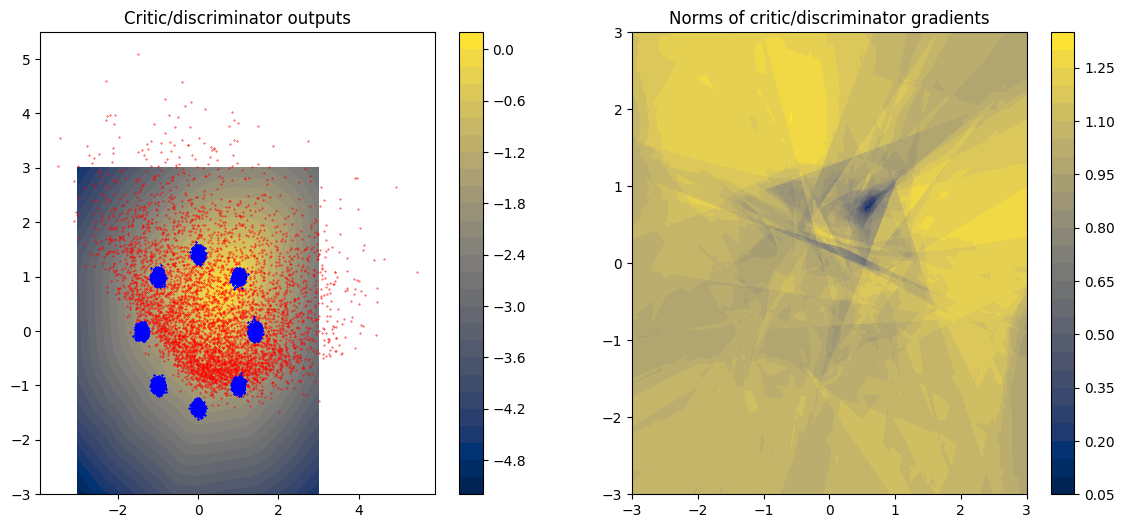

Epoch 100


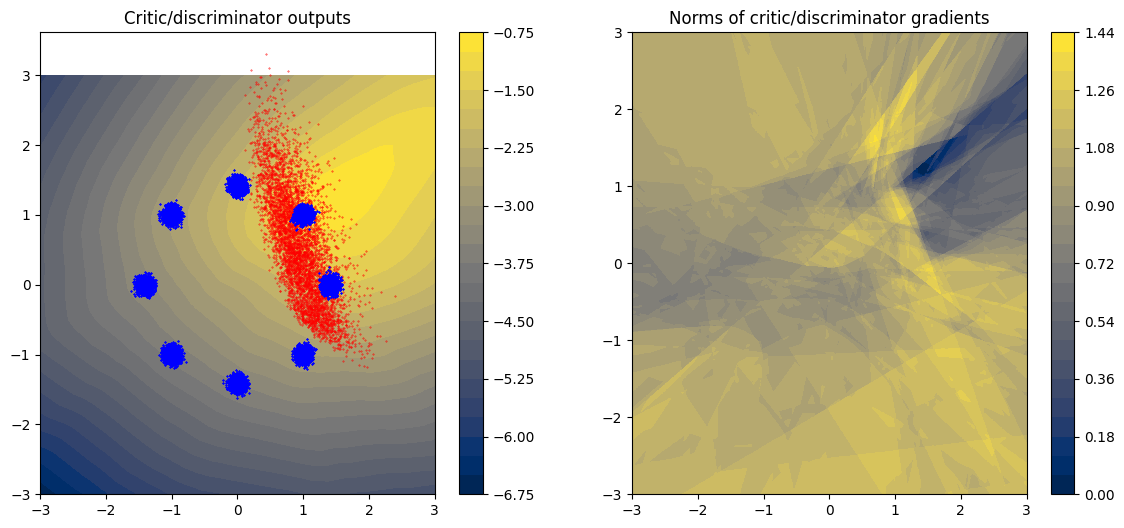

Epoch 150


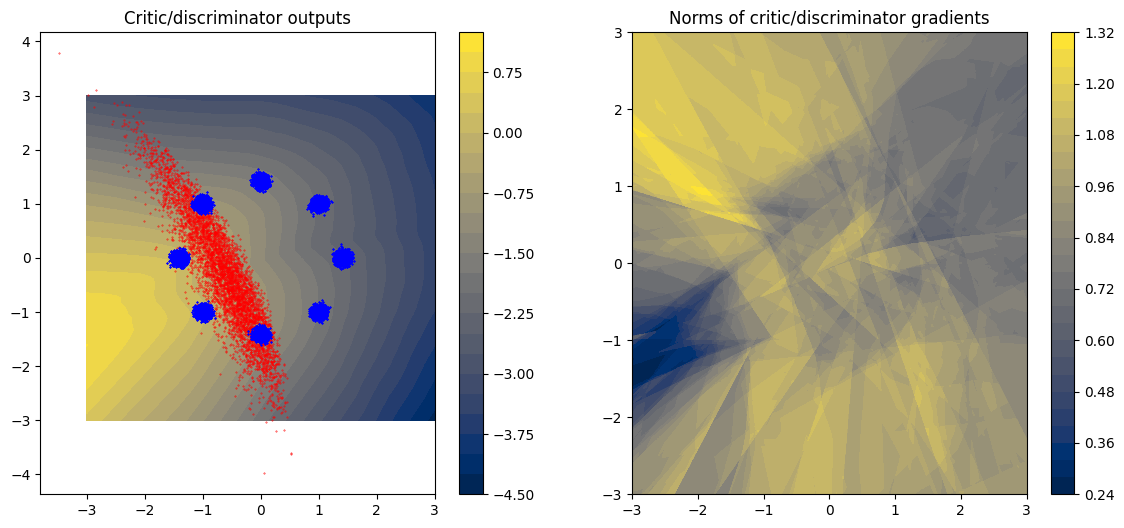

Epoch 200


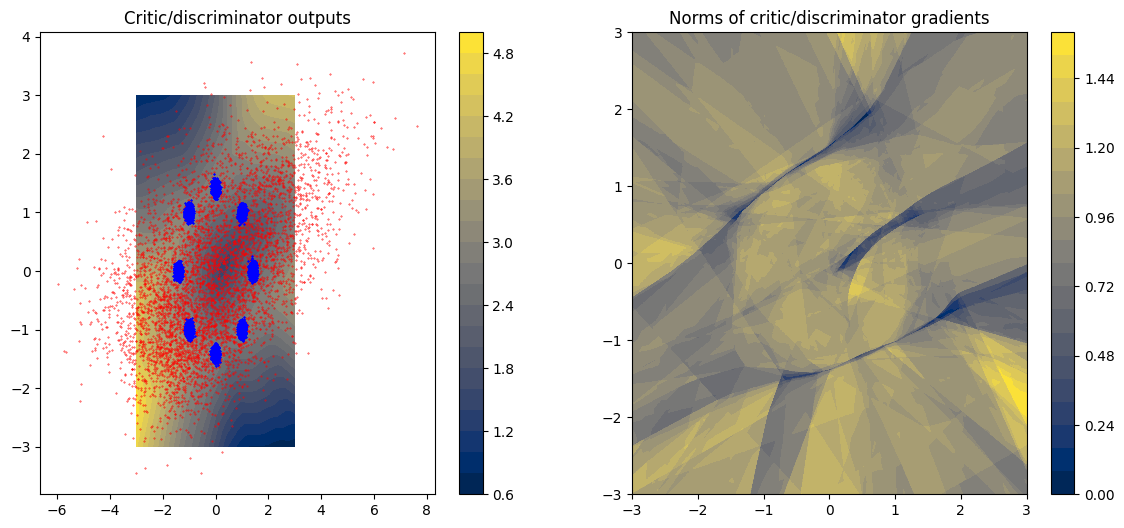

Epoch 250


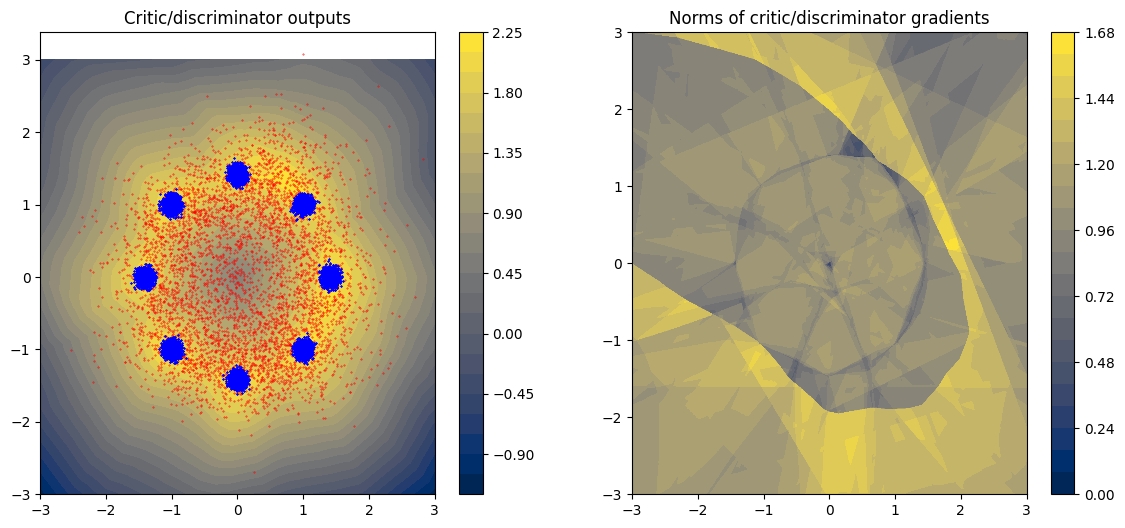

Epoch 300


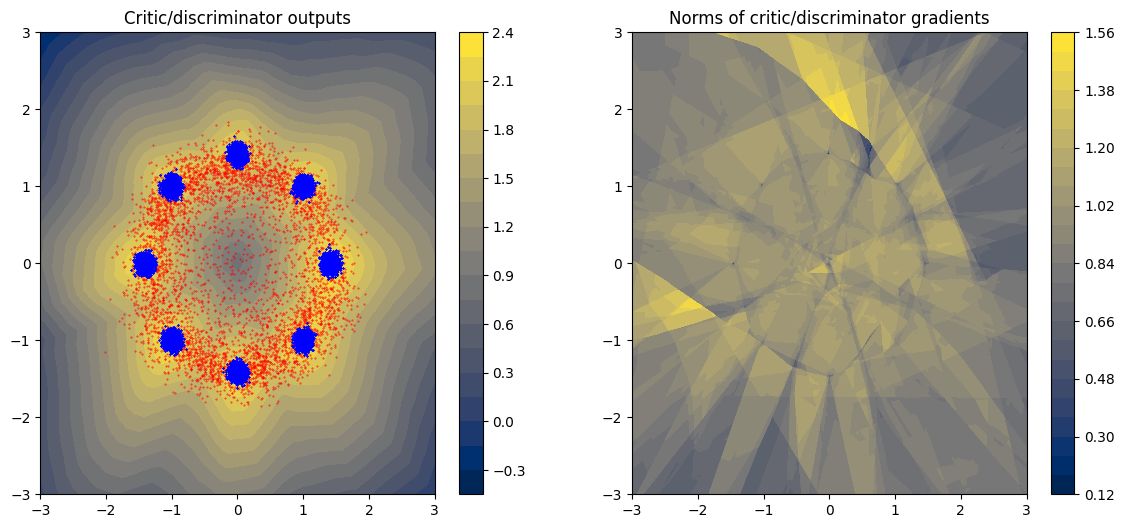

Epoch 350


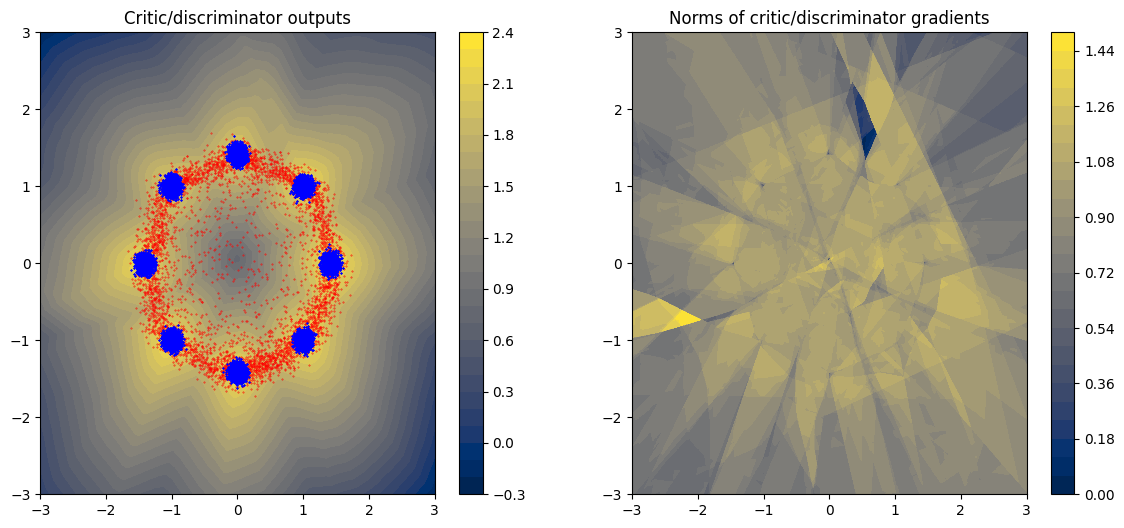

Epoch 400


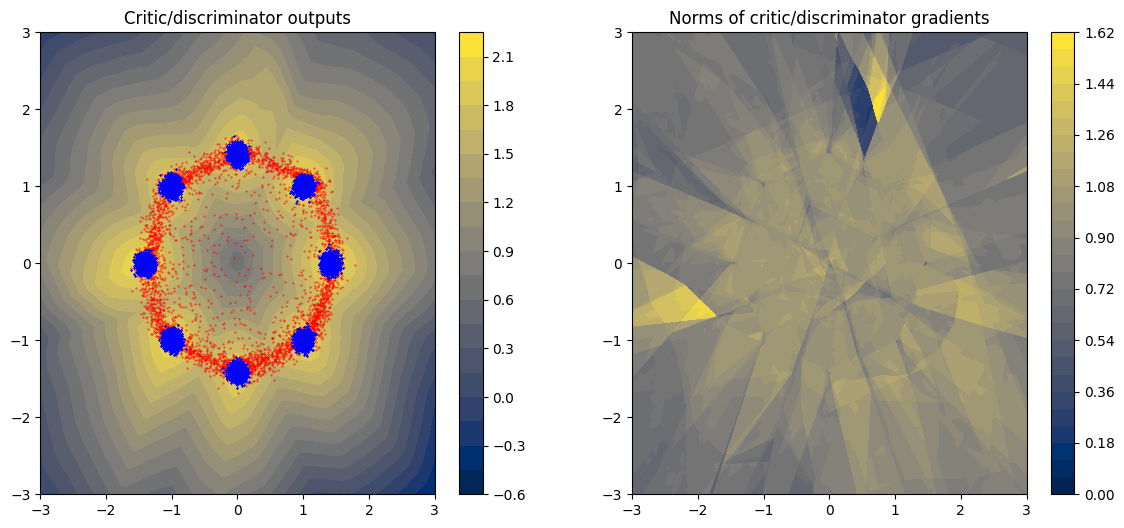

Epoch 450


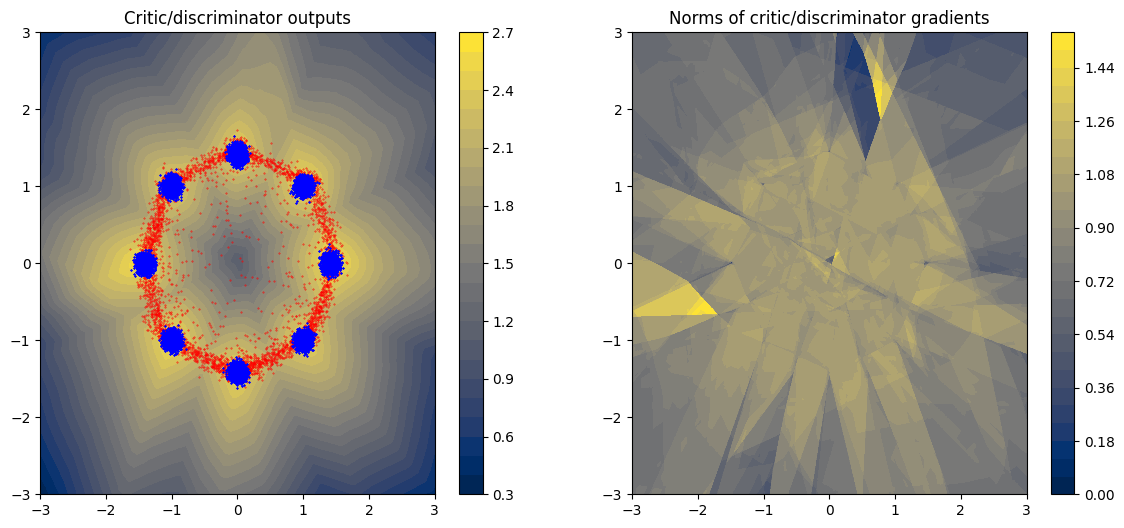

Epoch 500


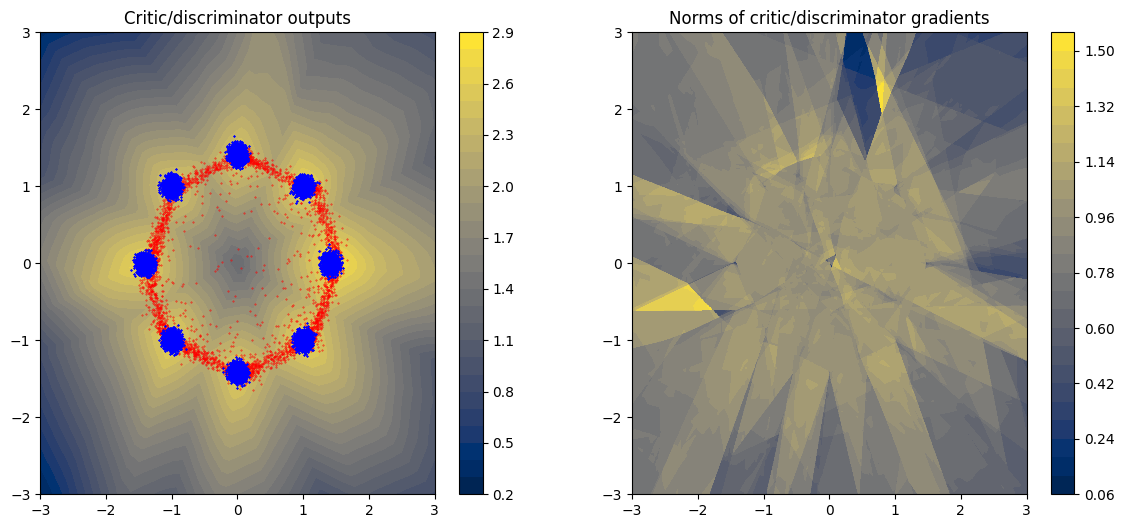

Epoch 550


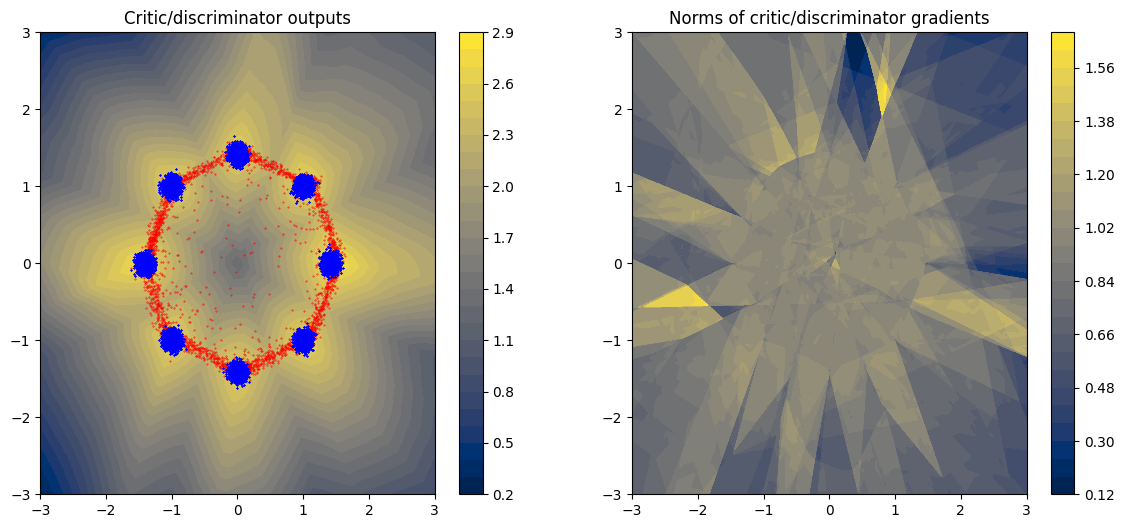

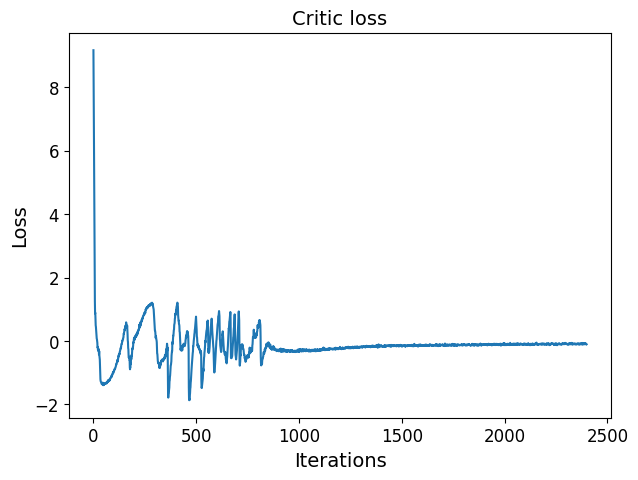

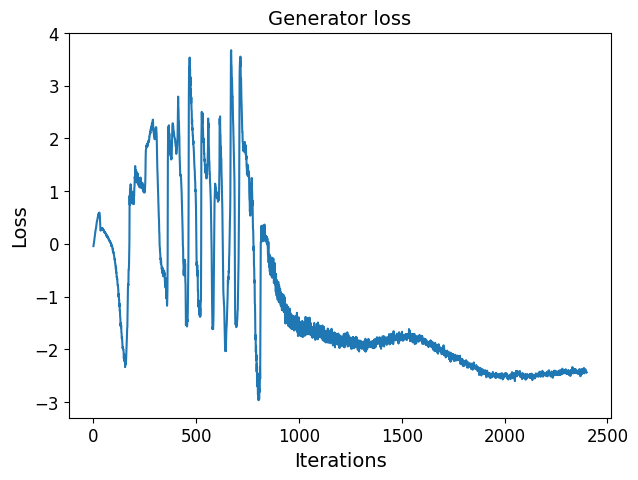

In [19]:
reset_seed()
BATCH_SIZE = 1024 # any adequate value
GEN_HIDDENS = [32, 128, 128, 32] # 4 layers with < 128 neurons would be enough
DISCR_HIDDENS = [64, 256, 256, 64] # 4 layers with < 128 neurons would be enough
CRITIC_STEPS = 5 # > 2
LR = 2e-4 # < 1e-2
GP_WEIGHT = 10 # > 5

N_EPOCHS = 600 # change it if you want

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

generator = WGANGP_MLPGenerator(16, GEN_HIDDENS, 2).to(DEVICE)
critic = WGANGP_MLPCritic(2, DISCR_HIDDENS, 1).to(DEVICE)

train_losses = train_wgan_gp(
    generator, 
    critic, 
    train_loader,
    critic_steps=CRITIC_STEPS, 
    batch_size=BATCH_SIZE, 
    n_epochs=N_EPOCHS,
    lr=LR,
    gp_weight=GP_WEIGHT,
    visualize_steps=50
)

plot_losses(train_losses['discriminator_losses'], 'Critic loss')
plot_losses(train_losses['generator_losses'], 'Generator loss')

In [46]:
samples, grid, critic_output, critic_grad_norms = make_inference(generator, critic)
visualize_GAN_output(samples, train_data, grid, critic_output, critic_grad_norms)

In [48]:
params = []
for param in critic.parameters():
    params.extend(param.detach().cpu().numpy().flatten())
plt.hist(params, bins=100)
plt.show()

### SNGAN

Spectral Normalization GAN [article](https://arxiv.org/pdf/1802.05957.pdf) replaces the weights in the critic $f(\mathbf{x}, \boldsymbol{\phi})$ by 
$$
    \mathbf{W}^{SN} = \frac{\mathbf{W}}{\|\mathbf{W}\|_2}.
$$

This ensures that $\| f\|_L \leq 1.$.

Power iteration method allows to efficiently compute $\| \mathbf{W} \|_2 = \sqrt{\lambda_{\text{max}}(\mathbf{W}^T \mathbf{W})}$.
    
The pseudocode of the method is:
* $\mathbf{u}_0$ -- random vector.
* for $k = 0, \dots, n - 1$: 
$$
    \mathbf{v}_{k+1} = \frac{\mathbf{W}^T \mathbf{u}_{k}}{\| \mathbf{W}^T \mathbf{u}_{k} \|}, \quad \mathbf{u}_{k+1} = \frac{\mathbf{W} \mathbf{v}_{k+1}}{\| \mathbf{W} \mathbf{v}_{k+1} \|}.
$$
* approximate the spectral norm
$$
    \| \mathbf{W} \|_2 = \sqrt{\lambda_{\text{max}}(\mathbf{W}^T \mathbf{W})} \approx \mathbf{u}_{n}^T \mathbf{W} \mathbf{v}_{n}.
$$


In [28]:
from sngan import train_sngan, SNFullyConnectedMLP

`SNGAN` generator model

In [29]:
class SNGAN_MLPGenerator(MLPGenerator):
    pass

`SNGAN` discriminator model

In [30]:
class SNMLPCritic(SNFullyConnectedMLP):
    pass

Playing with `SNGAN`

In [49]:
reset_seed()
BATCH_SIZE = 1024 # any adequate value
GEN_HIDDENS = [32, 128, 128, 32] # 4 layers with < 128 neurons would be enough
DISCR_HIDDENS = [64, 256, 256, 64] # 4 layers with < 128 neurons would be enough
CRITIC_STEPS = 5 # > 2
LR = 2e-4 # < 1e-2

N_EPOCHS = 20 # change it if you want

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

generator = MLPGenerator(16, GEN_HIDDENS, 2).to(DEVICE)
critic = SNMLPCritic(2, DISCR_HIDDENS, 1, power_iterations=2).to(DEVICE)

train_losses = train_sngan(
    generator, 
    critic, 
    train_loader,
    critic_steps=CRITIC_STEPS, 
    batch_size=BATCH_SIZE, 
    n_epochs=N_EPOCHS,
    lr=LR,
    visualize_steps=1
)

plot_losses(train_losses['discriminator_losses'], 'Critic loss')
plot_losses(train_losses['generator_losses'], 'Generator loss')

`SNGAN` training

In [50]:
reset_seed()
BATCH_SIZE = 1024 # any adequate value
GEN_HIDDENS = [32, 128, 128, 32] # 4 layers with < 128 neurons would be enough
DISCR_HIDDENS = [64, 256, 256, 64] # 4 layers with < 128 neurons would be enough
CRITIC_STEPS = 5 # > 2
LR = 2e-4 # < 1e-2

N_EPOCHS = 600 # change it if you want

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

generator = MLPGenerator(16, GEN_HIDDENS, 2).to(DEVICE)
critic = SNMLPCritic(2, DISCR_HIDDENS, 1, power_iterations=1).to(DEVICE)

train_losses = train_sngan(
    generator, 
    critic, 
    train_loader,
    critic_steps=CRITIC_STEPS, 
    batch_size=BATCH_SIZE, 
    n_epochs=N_EPOCHS,
    lr=LR,
    visualize_steps=50
)

plot_losses(train_losses['discriminator_losses'], 'Critic loss')
plot_losses(train_losses['generator_losses'], 'Generator loss')

In [51]:
params = []
for param in critic.parameters():
    params.extend(param.detach().cpu().numpy().flatten())
plt.hist(params, bins=100)
plt.show()

## Your questions regarding the homework

## GANs zoo

### Losses

- Vanilla GAN

    <img src="pics/gan_objective.jpg" width=800 height=800 />

    - Nonsaturating Vanilla GAN

- Wassersteing GAN 

    <img src="pics/WGAN_obj.jpg" width=800 height=800 />
    
    - WGAN-GP

- IPM GAN 

    **IPM** (Integral Probability Metric):
    
    $$
    \gamma_{\mathcal{F}}(\mathbb{P}, \mathbb{Q}) = \sup\limits_{f \in \mathcal{F}} \left\vert \int f d \mathbb{P} - \int f d \mathbb{Q} \right\vert,
    $$ 
    see [Sriperumbudur et. al.](https://arxiv.org/pdf/0901.2698.pdf) for the details on IPM metric.
    
    see [Mroueh et. al.](https://arxiv.org/pdf/1711.04894.pdf) for the examples of IPM GANs.
    
    
- GAN with Hinge loss

    <img src="pics/hinge_loss_GAN.png" width=800 height=800 />
    
    see [Lim et. al.](https://arxiv.org/pdf/1705.02894.pdf)

- fGAN 

    <img src="pics/fgan_loss.png" width=800 height=800 />
    
    article: [Nowozin et. al.](https://arxiv.org/pdf/1606.00709.pdf)
    
    * **Question:** By which parameter we maximize, and by which we minimize?
    
- ...

### Regularizations

- Weight clipping, Gradient penalty in WGAN

- Spectral Normalization (for general GAN architectures)

- $R_1$, $R_2$, $R_3$ regularizations (penalize discriminator gradients) [paper](https://arxiv.org/pdf/1801.04406.pdf), [paper2](https://arxiv.org/pdf/1705.09367.pdf)

- Improved techniques for training GANs [paper](https://arxiv.org/pdf/1606.03498.pdf)

- Orthogonal regularization [paper](https://arxiv.org/pdf/1809.11096.pdf)

    <img src="pics/ortho_reg.png" width=400 height=800 />

- ...